In [1]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
#from scipy.special import gamma
from scipy.stats import beta

In [2]:
x_min=0
x_max=500
def f_alpha(mu,sigma):
    return mu**2*(1-mu)/sigma**2-mu

def f_beta(mu,sigma):
    return mu*(1-mu)**2/sigma**2-1+mu

mu=114
sigma=0.5*mu
a=f_alpha(mu/(x_max-x_min),sigma/(x_max-x_min))
b=f_beta(mu/(x_max-x_min),sigma/(x_max-x_min))

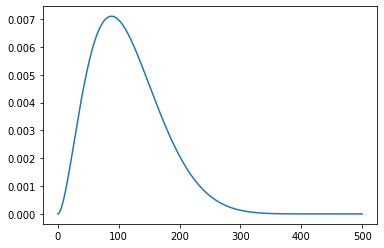

In [3]:
fig, ax = plt.subplots(1, 1)
x = np.linspace(0,
                x_max, 1000)
ax.plot(x, beta.pdf(x, a, b,0,x_max))
        #,
       #'r-', lw=5, alpha=0.6, label='beta pdf')

In [4]:
def create_database(N_households_df,E_sqm_df,E_min=0,E_max=500,sigma_out_of_mu=0.5):
    L_heating_sys=N_households_df.index.get_level_values('Heating_system').unique().to_list()
    dict_base={'Heating_system':[],'Energy_consumption':[],'Surface':[],'Number':[]}
    for hs in L_heating_sys:
        N=N_households_df.loc[hs,'Number']
        mu=E_sqm_df.loc[hs,'Energy_per_sqm']
        if N>0:
            sigma=sigma_out_of_mu*mu
            a=f_alpha(mu/(E_max-E_min),sigma/(E_max-E_min))
            b=f_beta(mu/(E_max-E_min),sigma/(E_max-E_min))
        for E in range(int(round(E_max))):
            dict_base['Heating_system'].append(hs)
            dict_base['Energy_consumption'].append(E)
            dict_base['Surface'].append(N_households_df.loc[hs,'Surface_avg'])
            if N>0:
                dict_base['Number'].append(int(round(N_households_df.loc[hs,'Number']*(beta.pdf(E,a,b,E_min,E_max)\
                                                                         +beta.pdf(E+1,a,b,E_min,E_max))/2)))
            else:
                dict_base['Number'].append(0)
    return pd.DataFrame(dict_base).set_index(['Heating_system','Energy_consumption'])

In [5]:
# Creation of the database for each country
N_households_df=pd.read_excel('Parameters_residential.xlsx',sheet_name="Number_of_households")
E_sqm_df=pd.read_excel('Parameters_residential.xlsx',sheet_name="Energy_per_sqm")

N_households_dict={}
E_sqm_dict={}

L_areas=list(N_households_df['AREA'].unique())
for area in L_areas:
    N_households_dict[area]=N_households_df[N_households_df.AREA==area].drop('AREA',axis=1).set_index('Heating_system')
    E_sqm_dict[area]=E_sqm_df[E_sqm_df.AREA==area].drop('AREA',axis=1).set_index('Heating_system')
    
Base_dict={}
for area in L_areas:
    Base_dict[area]=create_database(N_households_dict[area],E_sqm_dict[area])


In [6]:
def renovate(Database,N_reno,threshold,efficiency=0.3):
    Database_ret=Database.copy()
    E_max=max(Database.index.get_level_values('Energy_consumption'))
    L_heating_sys=Database.index.get_level_values('Heating_system').unique().to_list()
    N_to_renovate=0
    for E in range(int(np.floor(threshold)),E_max+1):
        for hs in L_heating_sys:
            N_to_renovate+=Database.loc[(hs,E),'Number']
    p_reno=min(N_reno/max(N_to_renovate,1),1)
    for E in range(int(np.floor(threshold)),E_max+1):
        E_new=int(round(E*(1-efficiency)))
        for hs in L_heating_sys:
            n=Database_ret.loc[(hs,E),'Number']
            n_renovated=min(int(round(n*p_reno)),n)
            Database_ret.loc[(hs,E),'Number']=n-n_renovated
            Database_ret.loc[(hs,E_new),'Number']+=n_renovated
    return Database_ret

In [8]:
# Test renovation Spain
N=Base_dict['ES']['Number'].sum()
L_heating_sys=Base_dict['ES'].index.get_level_values('Heating_system').unique().to_list()
E_sum=0
for E in range(500):
    for hs in L_heating_sys:
        E_sum+=(E+1/2)*Base_dict['ES'].loc[(hs,E),'Number']
print(E_sum/N)
db_ES_reno=renovate(Base_dict['ES'],120000,73.31)
E_sum=0
for E in range(500):
    for hs in L_heating_sys:
        E_sum+=(E+1/2)*db_ES_reno.loc[(hs,E),'Number']
print(E_sum/N)

43.30907724176037
43.13564637673578
